Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-cq17vlmi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-cq17vlmi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

################################
# 1) Setup Segment Anything model
################################
sam_checkpoint = "/content/drive/MyDrive/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"  # or "cpu"

# Create the SAM model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=128,
    pred_iou_thresh=0.80,
    stability_score_thresh=0.90,
    crop_n_layers=2,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=500,
)

In [ ]:
image_path = "/content/tongue.jpg"
img = Image.open(image_path).convert("RGB")
orig_width, orig_height = img.size
print(f"Original size: {orig_width}x{orig_height}")


Original size: 12433x7855


In [ ]:
masks = mask_generator.generate(img)
print(f"Found {len(masks)} masks in the downscaled image.")

Found 1017 masks in the downscaled image.


In [ ]:
def show_anns(anns, background_color='white'):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    height, width = sorted_anns[0]['segmentation'].shape
    # Create a canvas
    if background_color == 'white':
        base_img = np.ones((height, width, 4))
    elif background_color == 'black':
        base_img = np.zeros((height, width, 4))
    else:
        base_img = np.tile(np.array(background_color, dtype=float), (height, width, 1))

    base_img[:,:,3] = 1

    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])  # RGBA with alpha=0.35
        base_img[m] = color_mask
    ax.imshow(base_img)

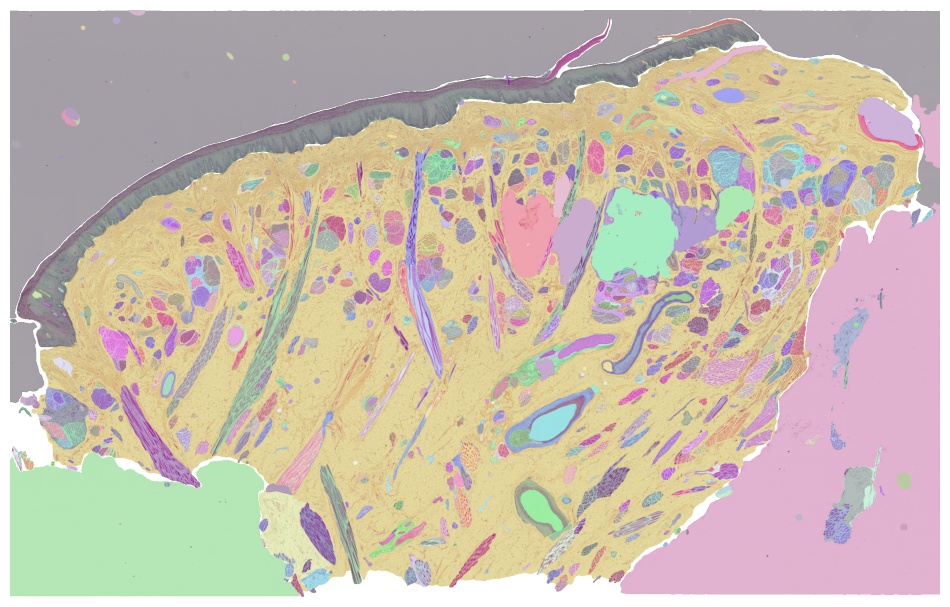

In [ ]:
plt.figure(figsize=(12, 24))
plt.imshow(img)
show_anns(masks)
plt.axis('off')
plt.savefig("segmented_image.jpg", bbox_inches='tight', pad_inches=0)
plt.savefig("segmented_image.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
!pip install svgwrite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import cv2
import svgwrite

# Create an SVG drawing with the same dimensions as the processed image.
height, width = img.shape[0:2]
dwg = svgwrite.Drawing("segmentation.svg", size=(f"{width}px", f"{height}px"))

# Loop through each segmentation mask.
for idx, mask in enumerate(masks):
    # The segmentation mask is a boolean numpy array; convert it to an 8-bit single channel image.
    seg_mask = (mask["segmentation"]).astype(np.uint8) * 255

    # Use OpenCV to find contours (borders) of the mask.
    contours, _ = cv2.findContours(seg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, create an SVG path.
    for contour in contours:
        # Remove redundant dimension (contour shape: (N, 1, 2) -> (N, 2))
        points = contour.squeeze(1)
        if len(points) < 2:
            continue

        # Build the SVG path data string.
        path_data = "M " + " L ".join(f"{x},{y}" for x, y in points) + " Z"

        # Add the path to the drawing.
        # Here, fill is set to "none" to just show the borders and stroke is black.
        dwg.add(dwg.path(d=path_data, fill="none", stroke="black", stroke_width=1))

# Save the SVG file.
dwg.save()
print("SVG file 'segmentation.svg' has been saved.")


SVG file 'segmentation.svg' has been saved.
